In [16]:
from glob import glob
from explicit_memory.utils import read_yaml
import pandas as pd

table = {"l": [], "m": []}
for results_path in sorted(glob("./training_results/*/*/*/*/*/*/results.yaml")):
    train_path = results_path.replace("results.yaml", "train.yaml")

    results = read_yaml(results_path)
    train = read_yaml(train_path)

    test_score = results["test_score"]
    sorted_val = sorted(results["validation_score"], key=lambda x: x["mean"])
    val_score = sorted_val[-1]

    table[train["env_config"]["room_size"]].append(
        {
            "test_mean": test_score["mean"],
            "test_std": test_score["std"],
            "val_mean": val_score["mean"],
            "val_std": val_score["std"],
            "gamma": train["gamma"],
            "split_reward_training": train["split_reward_training"],
            "pretrain_semantic": train["pretrain_semantic"],
            "randomize": train["env_config"]["randomize_observations"],
            "dir": results_path.split("/")[-2],
        }
    )

for size in ["l", "m"]:
    table[size] = sorted(table[size], key=lambda x: x["test_mean"], reverse=True)


In [17]:
pd.DataFrame(table["m"])

,test_mean,test_std,val_mean,val_std,gamma,split_reward_training,pretrain_semantic,randomize,dir
0,15.0,141.92,15.8,127.85,0.99,False,False,objects,2023-12-20 20:04:31.826427
1,-32.6,162.77,32.6,173.19,0.90,False,False,objects,2023-12-20 18:34:12.725827
2,-39.6,275.70,124.6,124.97,0.99,False,False,none,2023-12-20 20:04:31.810656
3,-47.0,298.14,43.2,198.95,0.90,True,False,none,2023-12-20 05:02:47.804211
4,-58.6,213.18,-174.0,295.42,0.90,True,False,objects_middle,2023-12-20 06:23:19.101202
5,-89.6,136.44,-11.6,236.11,0.90,True,exclude_walls,none,2023-12-20 07:43:52.646939
6,-98.6,232.14,28.2,245.62,0.90,False,False,objects,2023-12-20 00:50:31.925415
7,-112.2,247.48,-41.2,219.98,0.99,False,False,none,2023-12-20 17:05:39.066179
8,-126.2,322.69,25.4,206.37,0.90,False,False,none,2023-12-20 15:36:15.258867
9,-152.0,318.37,-10.4,227.15,0.90,True,False,objects,2023-12-20 05:02:47.755822


In [18]:
pd.DataFrame(table["l"])

,test_mean,test_std,val_mean,val_std,gamma,split_reward_training,pretrain_semantic,randomize,dir
0,-188.4,88.76,-150.0,86.57,0.99,False,False,none,2023-12-20 17:42:29.176932
1,-260.2,231.97,-206.8,105.54,0.90,False,False,none,2023-12-20 09:23:14.595377
2,-268.2,184.68,-204.4,233.55,0.90,False,False,objects,2023-12-20 19:11:29.686407
3,-299.2,203.38,-333.6,217.82,0.90,True,False,objects_middle,2023-12-20 13:56:51.574687
4,-309.8,171.23,-272.2,129.29,0.90,False,exclude_walls,objects,2023-12-20 11:11:21.804522
5,-359.4,158.13,-267.0,207.00,0.90,False,False,none,2023-12-20 16:12:35.820404
6,-363.0,174.43,-281.8,176.58,0.90,False,False,objects_middle,2023-12-20 10:16:57.334376
7,-378.0,81.08,-173.0,133.63,0.90,False,False,objects,2023-12-20 09:23:14.585957
8,-386.6,276.78,-266.0,267.27,0.90,False,False,none,2023-12-20 19:11:29.672132
9,-411.4,131.88,-295.0,232.00,0.90,False,exclude_walls,none,2023-12-20 11:11:21.784181


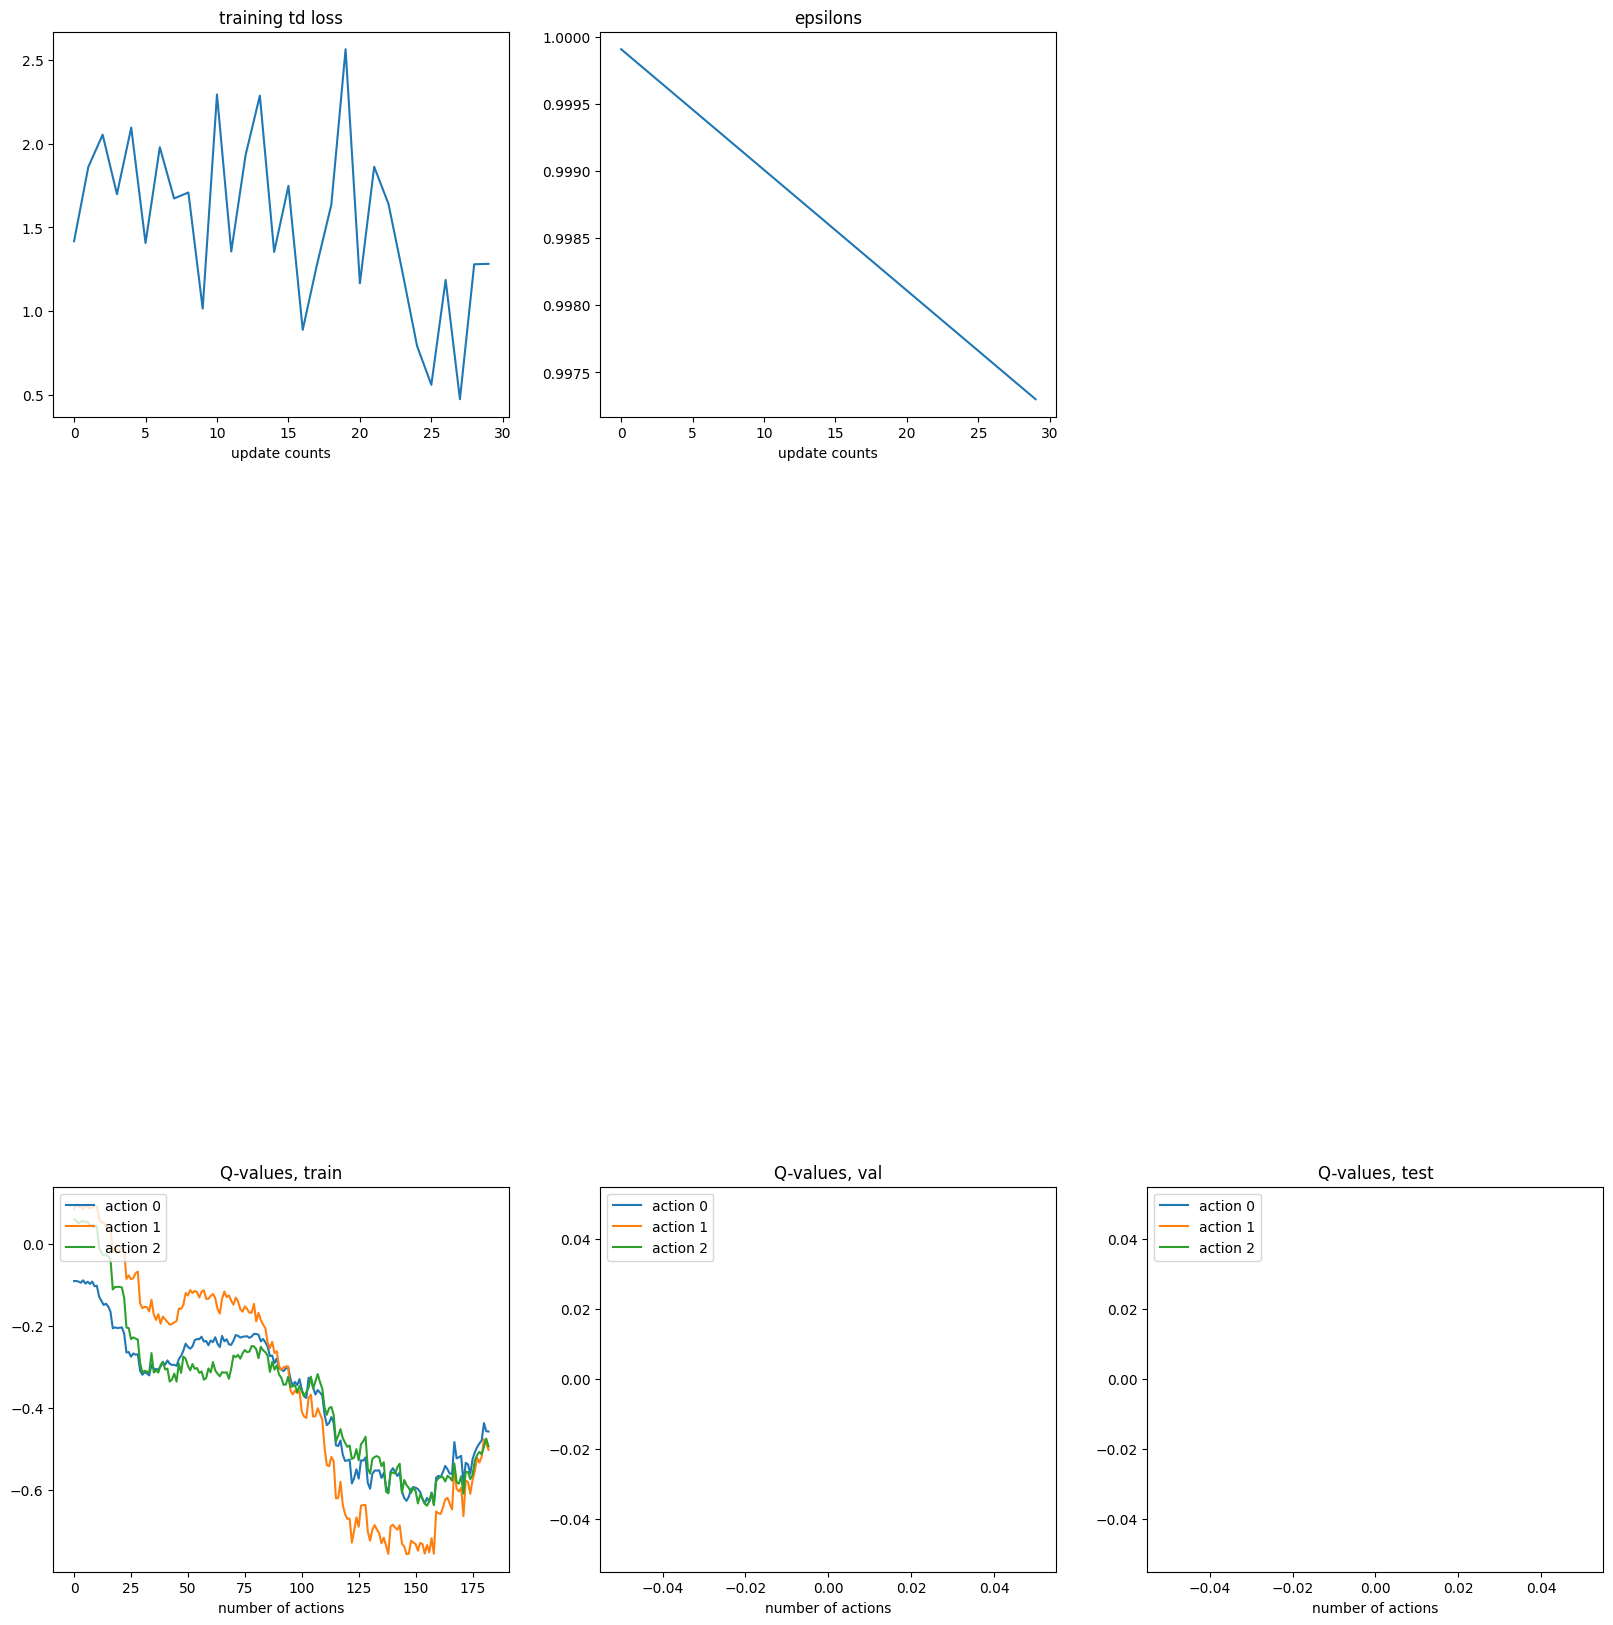

KeyboardInterrupt: 

In [3]:
%matplotlib inline
import logging

logger = logging.getLogger()
logger.disabled = True

import random

from copy import deepcopy
from tqdm.auto import tqdm
from agent.dqn import DQNMMAgent

room_size = "xl"

if room_size == "m":
    capacity = {
        "episodic": 8,
        "episodic_agent": 0,
        "semantic": 8,
        "semantic_map": 0,
        "short": 1,
    }
elif room_size == "l":
    capacity = {
        "episodic": 16,
        "episodic_agent": 0,
        "semantic": 16,
        "semantic_map": 0,
        "short": 1,
    }
elif room_size == "xl":
    capacity = {
        "episodic": 32,
        "episodic_agent": 0,
        "semantic": 32,
        "semantic_map": 0,
        "short": 1,
    }

capacity = {
    "episodic": 8,
    "episodic_agent": 0,
    "semantic": 8,
    "semantic_map": 0,
    "short": 1,
}

config = {
    "question_prob": 1.0,
    "terminates_at": 99,
    "randomize_observations": "all",
    "room_size": room_size,
    "rewards": {"correct": 1, "wrong": -1, "partial": -1},
    "make_everything_static": False,
    "num_total_questions": 1000,
    "question_interval": 1,
    "include_walls_in_observations": True,
}

params = {
    "env_str": "room_env:RoomEnv-v2",
    "max_epsilon": 1.0,
    "min_epsilon": 0.1,
    "epsilon_decay_until": 100 * 100,
    "gamma": 0.9,
    "capacity": capacity,
    "nn_params": {
        "hidden_size": 64,
        "num_layers": 2,
        "embedding_dim": 64,
        "v1_params": None,
        "v2_params": {},
        "memory_of_interest": [
            "episodic",
            "semantic",
            "short",
        ],
        "fuse_information": "sum",
        "include_positional_encoding": True,
        "max_timesteps": config["terminates_at"] + 1,
        "max_strength": config["terminates_at"] + 1,
    },
    "num_iterations": 100 * 100,
    "replay_buffer_size": 100 * 100,
    "warm_start": 100 * 100 / 10,
    "batch_size": 32,
    "target_update_interval": 10,
    "pretrain_semantic": False,
    "run_test": True,
    "num_samples_for_results": 100,
    "train_seed": 5,
    "plotting_interval": 10,
    "device": "cpu",
    "test_seed": 0,
    "qa_policy": "episodic_semantic",
    "explore_policy": "avoid_walls",
    "env_config": config,
    "ddqn": True,
    "dueling_dqn": True,
    "split_reward_training": None,
    "default_root_dir": './training_results/TRASH',
    "run_handcrafted_baselines": [
        {
            "mm": mm,
            "qa": qa,
            "explore": explore,
            "pretrain_semantic": pretrain_semantic,
        }
        for mm in ["random", "episodic", "semantic"]
        for qa in ["episodic_semantic"]
        for explore in ["random", "avoid_walls"]
        for pretrain_semantic in [False, "exclude_walls"]
    ],
}


agent = DQNMMAgent(**params)
agent.train()

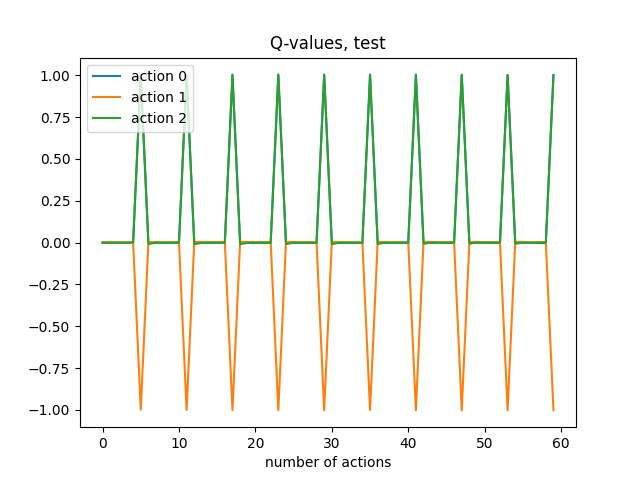

In [1]:
%matplotlib widget
from explicit_memory.utils import read_pickle

import matplotlib.pyplot as plt

agent = read_pickle('./training_results/xxs/gamma=0/agent.pkl')
plt.figure()
plt.title("Q-values, test");
for action_number in range(agent.dqn.n_actions):
    plt.plot(
        [q_values_[action_number] for q_values_ in agent.q_values["test"]],
        label=f"action {action_number}",
    )
plt.legend(loc="upper left");
plt.xlabel("number of actions");

These q values make sense. There are 6 observations:

1. north
2. east
3. south 
4. west 
5. sta 
6. agent (this is where the reward +1 comes)

Note that the q values of the action 0 and action 2 are almost identical so that's why you can't see the q values for action 0

The optimal q value for the state and action is q = 1 + (0.0)^1* 0 + (0.0)^2* 0 + (0.0)^3* 0 + (0.0)^4* 0 + (0.0)^5* 0 + (0.0)^6* 1 + ... = 1

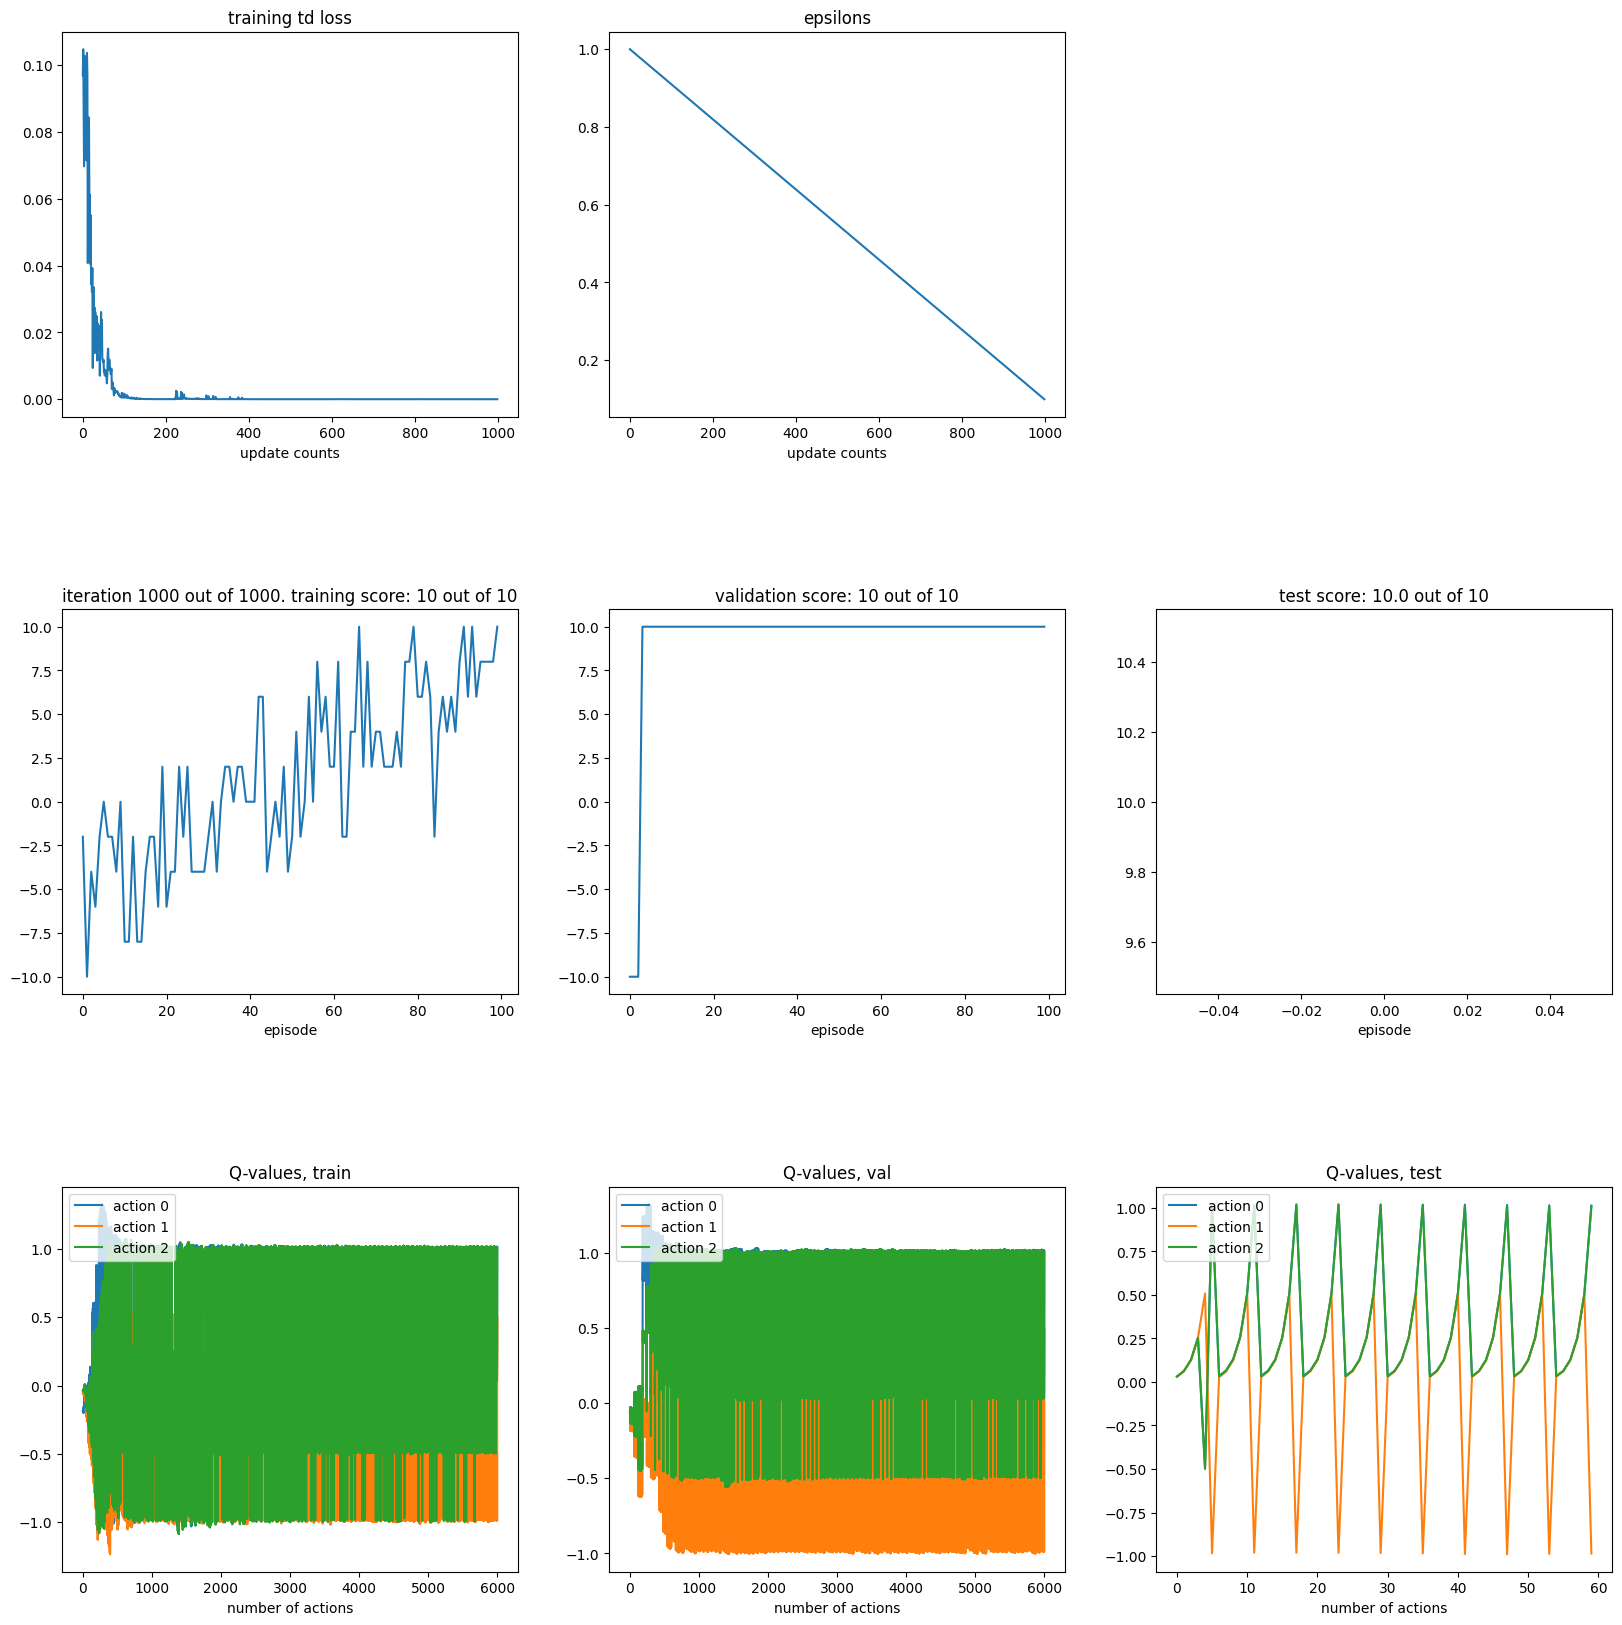

In [8]:
%matplotlib inline
params["gamma"] = 0.5
agent = DQNMMAgent(**params)
agent.train()

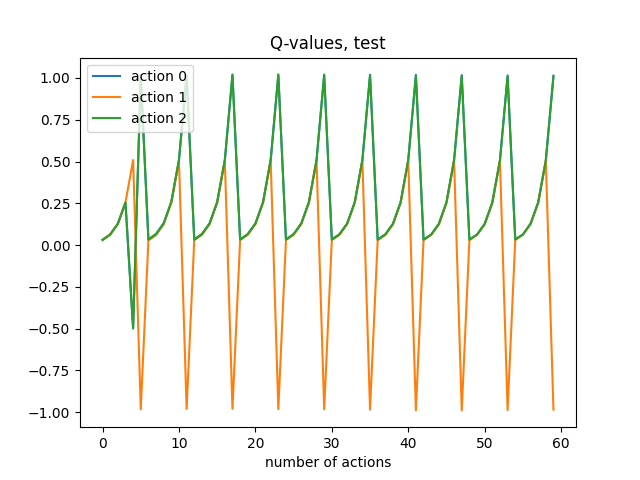

In [2]:
%matplotlib widget
from explicit_memory.utils import read_pickle

import matplotlib.pyplot as plt
agent = read_pickle('./training_results/xxs/gamma=0.5/agent.pkl')
plt.figure()
plt.title("Q-values, test");
for action_number in range(agent.dqn.n_actions):
    plt.plot(
        [q_values_[action_number] for q_values_ in agent.q_values["test"]],
        label=f"action {action_number}",
    )
plt.legend(loc="upper left");
plt.xlabel("number of actions");

The optimal q value for the state and action is q = 1 + (0.5)^1* 0 + (0.5)^2* 0 + (0.5)^3* 0 + (0.5)^4* 0 + (0.5)^5* 0 + (0.5)^6* 1 + ... = 1.015 in the beginning, and it starts to decline.

Since 0.5^6 = 0.015

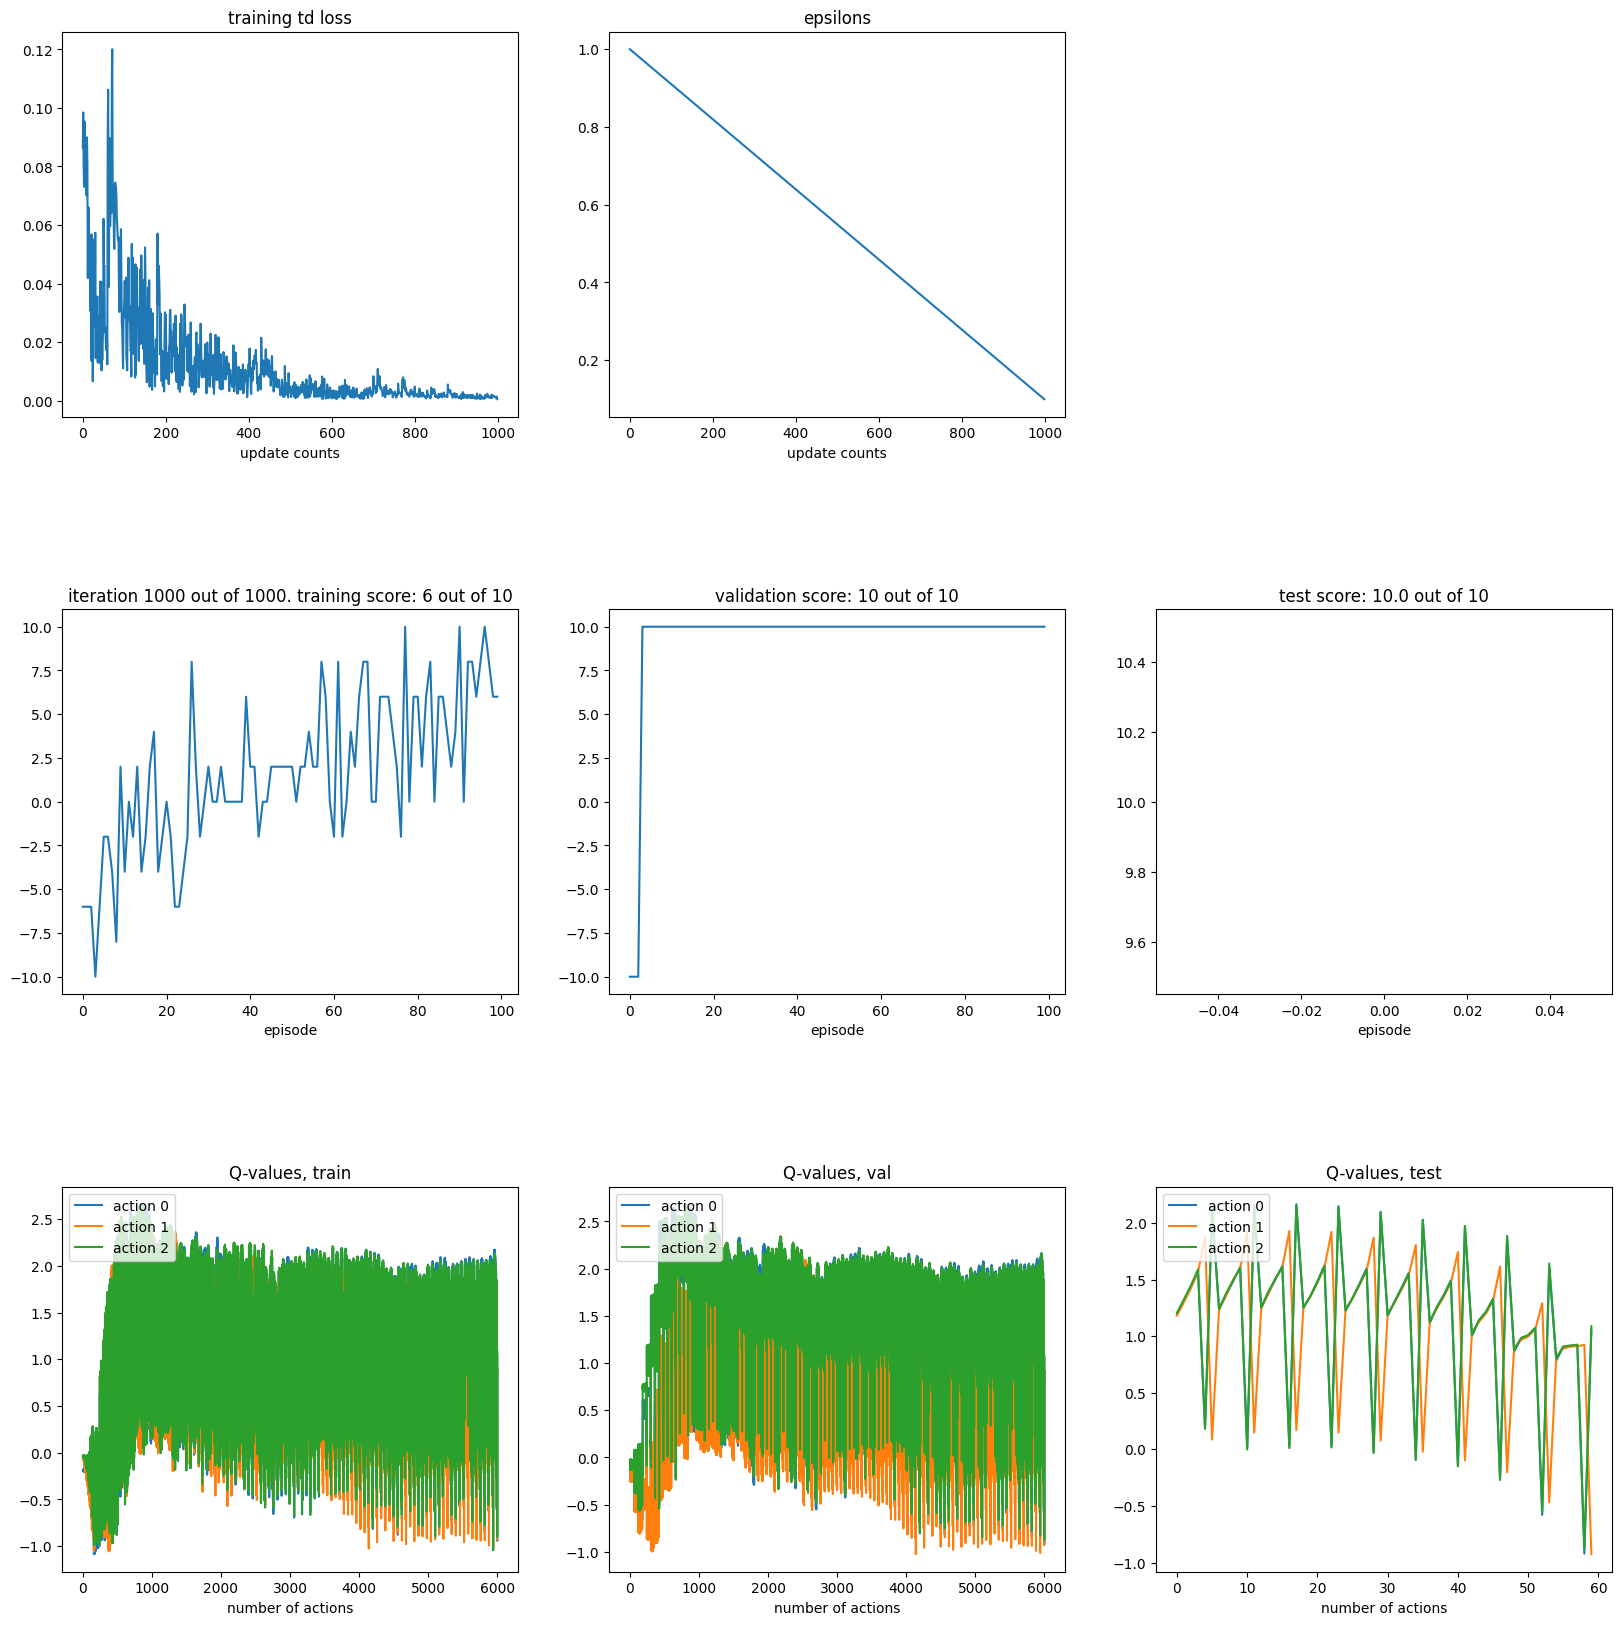

In [12]:
%matplotlib inline
params["gamma"] = 0.9
agent = DQNMMAgent(**params)
agent.train()

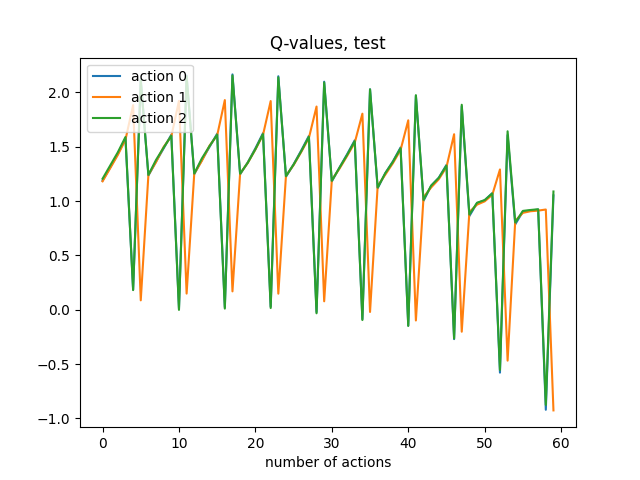

In [3]:
%matplotlib widget
from explicit_memory.utils import read_pickle

import matplotlib.pyplot as plt
agent = read_pickle('./training_results/xxs/gamma=0.9/agent.pkl')
plt.figure()
plt.title("Q-values, test");
for action_number in range(agent.dqn.n_actions):
    plt.plot(
        [q_values_[action_number] for q_values_ in agent.q_values["test"]],
        label=f"action {action_number}",
    )
plt.legend(loc="upper left");
plt.xlabel("number of actions");

The optimal q value for the state and action is q = 1 + (0.9)^1* 0 + (0.9)^2* 0 + (0.9)^3* 0 + (0.9)^4* 0 + (0.9)^5* 0 + (0.9)^6* 1 + ... =  1 / (1-0.531) = 2.132 in the beginning, and it starts to decline.

Since 0.9^6 = 0.531

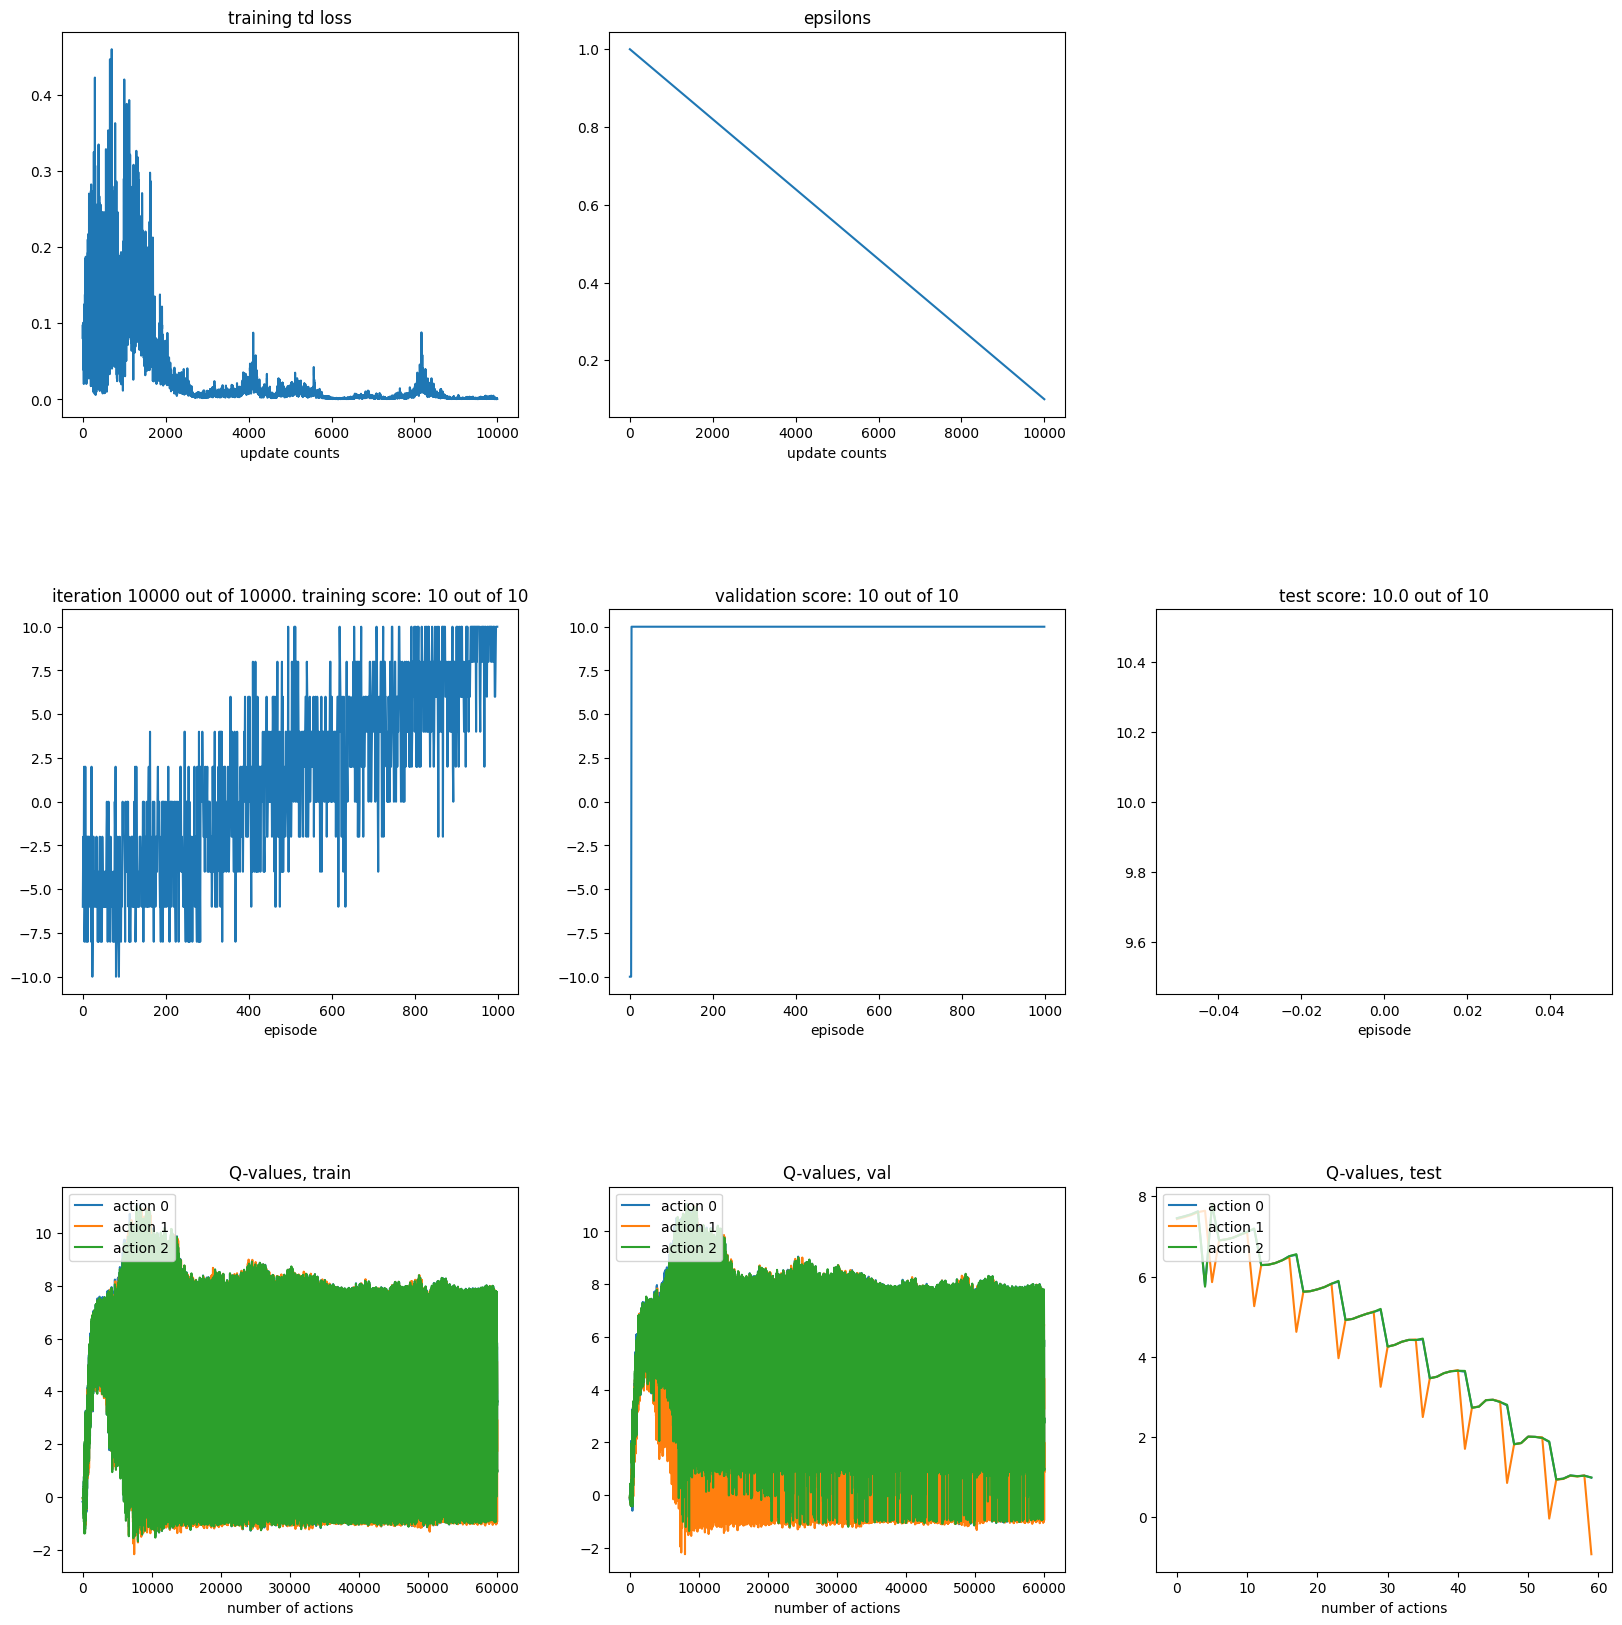

In [18]:
%matplotlib inline
params["gamma"] = 0.99

# we need a longer training time to see the effect of gamma
params["epsilon_decay_until"] = 10* 1000
params["num_iterations"] = 10* 1000
params["replay_buffer_size"] = 10* 1000

agent = DQNMMAgent(**params)
agent.train()

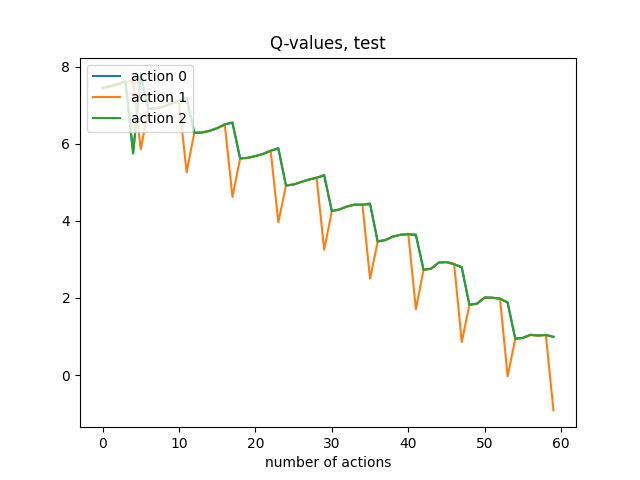

In [4]:
%matplotlib widget
from explicit_memory.utils import read_pickle

import matplotlib.pyplot as plt
agent = read_pickle('./training_results/xxs/gamma=0.99/agent.pkl')
plt.figure()
plt.title("Q-values, test");
for action_number in range(agent.dqn.n_actions):
    plt.plot(
        [q_values_[action_number] for q_values_ in agent.q_values["test"]],
        label=f"action {action_number}",
    )
plt.legend(loc="upper left");
plt.xlabel("number of actions");

The optimal q value for the state and action is q = 1 + (0.99)^1* 0 + (0.99)^2* 0 + (0.99)^3* 0 + (0.99)^4* 0 + (0.99)^5* 0 + (0.99)^6* 1 + ... =  1 / (1-0.941480149401) = 17.08 in the beginning, and it starts to decline.

Since 0.99^6 = 0.941